In [8]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import random
import warnings
import requests
from io import BytesIO
from zipfile import ZipFile
warnings.filterwarnings("ignore")

In [9]:
data_url = 'http://files.grouplens.org/datasets/movielens/ml-latest.zip'
res = requests.get(data_url)
file = ZipFile(BytesIO(res.content)).open('ml-latest/ratings.csv')
ratings = pd.read_csv(file)


## Exploratory Data Analysis

In [10]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [ ]:
# Number of Movies
ratingsGroupedByMovie = ratings.groupby(by=["movieId"]).count().reset_index()

#Number of Users
ratingsGroupedByusers = ratings.groupby(by=["userId"]).count().reset_index()

TotalMovies = ratingsGroupedByMovie.shape[0]
TotalUsers = ratingsGroupedByusers.shape[0]
print("The total number of users are",TotalUsers,"and the total number of movies are",TotalMovies)

The total number of users are 283228 and the total number of movies are 53889


In [ ]:
user_freq=ratings.groupby('userId', as_index=False).agg(num_movies=('movieId','count'))
movie_freq=ratings.groupby('movieId', as_index=False).agg(num_users=('userId','count'))

In [ ]:
user_freq['num_movies'].to_frame().describe()

,num_movies
count,283228.000000
mean,97.989761
std,212.760722
min,1.000000
25%,15.000000
50%,30.000000
75%,95.000000
max,23715.000000


The average number of movies rated per user is 98 and 50% of the users rated less then or equal to 30 movies while 75% of them have rated less than or equal to 95 movies.

In [ ]:
movie_freq['num_users'].to_frame().describe()

,num_users
count,53889.000000
mean,515.011301
std,2934.758939
min,1.000000
25%,2.000000
50%,7.000000
75%,48.000000
max,97999.000000


Total movies = ~54k. On an average a movie has been rated by 515 users, 50% of the movies have been rated by less than or equal to 7 users while 75% of the movies have been rated by less than or equal to 48 users

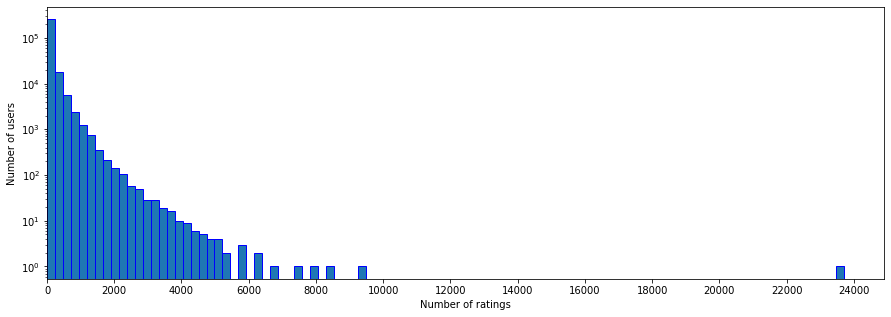

In [ ]:
plt.figure(figsize=(15,5))
plt.hist(user_freq['num_movies'], bins=100, edgecolor='b', log=True)
plt.xlim(0,)
plt.xticks(np.arange(0,25000,2000))
plt.xlabel('Number of ratings')
plt.ylabel('Number of users')
plt.show()

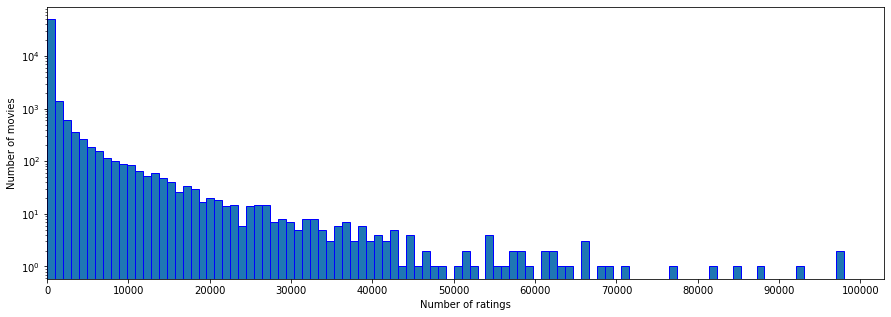

In [ ]:
plt.figure(figsize=(15,5))
plt.hist(movie_freq['num_users'], bins=100, edgecolor='b', log=True)
plt.xlim(0,)
plt.xticks(np.arange(0,110000,10000))
plt.xlabel('Number of ratings')
plt.ylabel('Number of movies')
plt.show()

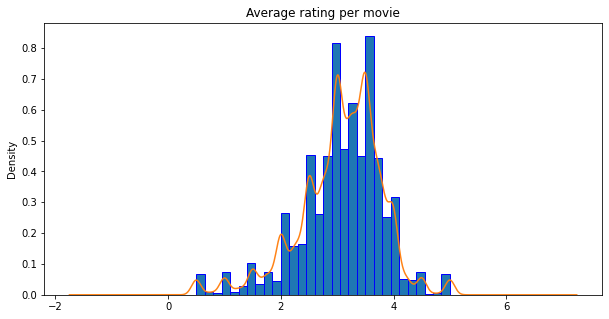

In [ ]:
df_mv_gp = ratings[['movieId','rating']].groupby('movieId').agg(mean_rating=('rating','mean'))
df_mv_gp.hist(bins=30, grid=False, edgecolor='b', density=True, figsize=(10,5))
df_mv_gp['mean_rating'].plot(grid=False, alpha=10, kind='kde')
plt.title('Average rating per movie')
plt.show()

Density plot of mean rating of movies indicate a multimodal distribution achieving its bimodal peaks around the centre of rating scale

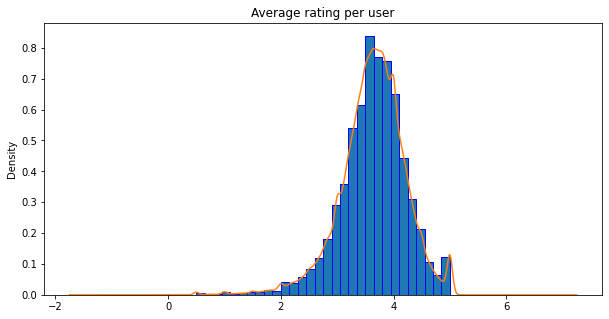

In [ ]:
df_ur_gp = ratings[['userId','rating']].groupby('userId').agg(mean_rating=('rating','mean'))
df_ur_gp.hist(bins=30, grid=False, edgecolor='b', density=True, figsize=(10,5))
df_ur_gp['mean_rating'].plot(grid=False, alpha=10, kind='kde')
plt.title('Average rating per user')
plt.show()

Density plot of mean rating per user indicates a left skewed distribution with mean approximately 3.6


### Filtering users who have rated more than 10 movies and movies that have more than 1000 ratings

In [ ]:
# Only keeping Users who have rated more than 10 movies 
ratings1 = ratings[ratings.groupby("userId")['userId'].transform('size')>10]
# Only keeping Movies which have been rated more than 1000 times
ratings1 = ratings1[ratings1.groupby("movieId")['movieId'].transform('size')>1000]

# Number of Movies after filtering
ratingsGroupedByMovie_filtered = ratings1.groupby(by=["movieId"]).count().reset_index()

#Number of Users after filtering
ratingsGroupedByusers_filtered = ratings1.groupby(by=["userId"]).count().reset_index()

TotalMovies_filtered = ratingsGroupedByMovie_filtered.shape[0]
TotalUsers_filtered = ratingsGroupedByusers_filtered.shape[0]
print("The total number of users after filtering are",TotalUsers_filtered,"and the total number of movies after filtering are",TotalMovies_filtered)

The total number of users after filtering are 236649 and the total number of movies after filtering are 3914


# Data Sampling


## Method 1 : Stratified Sampling : Preserving the total number of movies depending upon the number of times they have been rated (Preserving the proportion/distribution of our original dataset)

In [ ]:
def create_stratified_sample(n=100):
  np.random.seed(10)
  # N --> Total Sample size desired
  N = 1000000
  final_ratings = ratings1.groupby('movieId', group_keys=False).apply(lambda x: x.sample(int(np.rint(N*len(x)/len(ratings1))))).sample(frac=1).reset_index(drop=True)

  return final_ratings

In [ ]:
final_ratings1 = create_stratified_sample()

In [ ]:
print("The total number of users after stratified sampling are", final_ratings1.groupby(by=["userId"]).count().shape[0])

The total number of users after stratified sampling are 180289


In [ ]:
print("The total number of movies after stratified sampling are", final_ratings1.groupby(by=["movieId"]).count().shape[0])

The total number of movies after stratified sampling are 3914


In [ ]:
final_ratings1_movie_grouping = final_ratings1.groupby(by=["movieId"]).count().reset_index()
print("Minimum number of ratings per movie: ",final_ratings1_movie_grouping["userId"].mean())

Minimum number of ratings per movie:  255.4982115482882


In [ ]:
user_freq1=final_ratings1.groupby('userId', as_index=False).agg(num_movies=('movieId','count'))
movie_freq1 = final_ratings1.groupby('movieId', as_index=False).agg(num_users=('userId','count'))

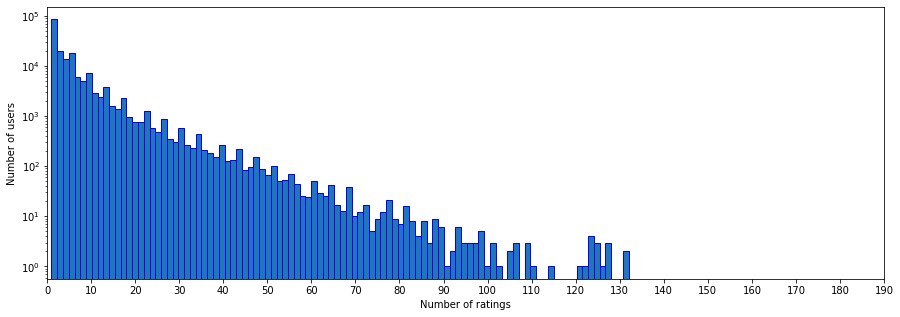

In [ ]:
plt.figure(figsize=(15,5))
plt.hist(user_freq1['num_movies'], bins=100, edgecolor='b', log=True)
plt.xlim(0,)
plt.xticks(np.arange(0,200,10))
plt.xlabel('Number of ratings')
plt.ylabel('Number of users')
plt.show()

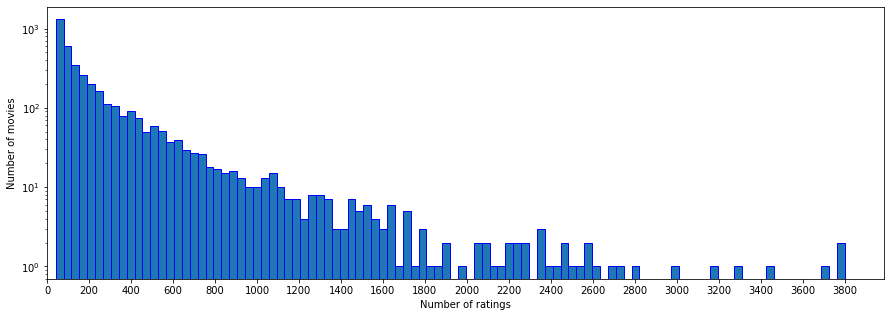

In [ ]:
plt.figure(figsize=(15,5))
plt.hist(movie_freq1['num_users'], bins=100, edgecolor='b', log=True)
plt.xlim(0,)
plt.xticks(np.arange(0,4000,200))
plt.xlabel('Number of ratings')
plt.ylabel('Number of movies')
plt.show()

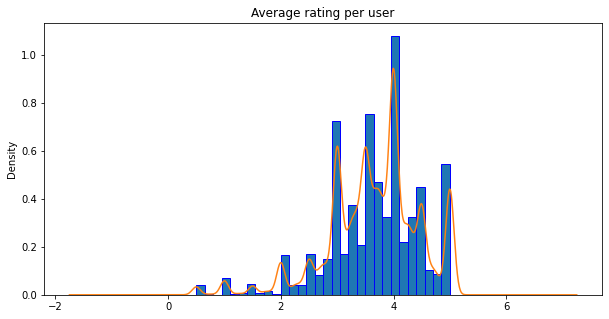

In [ ]:
df_ur_gp1 = final_ratings1[['userId','rating']].groupby('userId').agg(mean_rating=('rating','mean'))
df_ur_gp1.hist(bins=30, grid=False, edgecolor='b', density=True, figsize=(10,5))
df_ur_gp1['mean_rating'].plot(grid=False, alpha=10, kind='kde')
plt.title('Average rating per user')
plt.show()

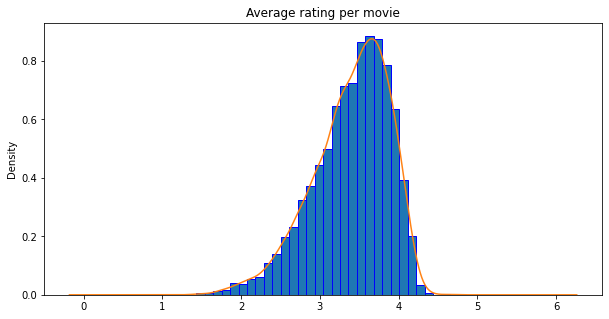

In [ ]:
df_mv_gp1 = final_ratings1[['movieId','rating']].groupby('movieId').agg(mean_rating=('rating','mean'))
df_mv_gp1.hist(bins=30, grid=False, edgecolor='b', density=True, figsize=(10,5))
df_mv_gp1['mean_rating'].plot(grid=False, alpha=10, kind='kde')
plt.title('Average rating per movie')
plt.show()

## Method 2 : Sampling Based on Timestamp 

### Observing the trend of of movies rated for per given years

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime
ratings1_with_date = ratings1
ratings1_with_date['date'] = [datetime.fromtimestamp(x) for x in ratings1_with_date['timestamp']]
ratings1_with_date['date'] = pd.to_datetime(ratings1_with_date['date'])
ratings1_with_date['year'] = ratings1_with_date['date'].dt.year
ratings1_with_date

,userId,movieId,rating,timestamp,date,year
0,1,307,3.5,1256677221,2009-10-27 21:00:21,2009
1,1,481,3.5,1256677456,2009-10-27 21:04:16,2009
2,1,1091,1.5,1256677471,2009-10-27 21:04:31,2009
3,1,1257,4.5,1256677460,2009-10-27 21:04:20,2009
4,1,1449,4.5,1256677264,2009-10-27 21:01:04,2009
...,...,...,...,...,...,...
27753438,283228,8228,5.0,1354137317,2012-11-28 21:15:17,2012
27753439,283228,8542,4.5,1379882795,2013-09-22 20:46:35,2013
27753441,283228,34405,4.5,1379882889,2013-09-22 20:48:09,2013
27753442,283228,44761,4.5,1354159524,2012-11-29 03:25:24,2012


Text(0.5, 1.0, 'Frequency of rating of movies per year')

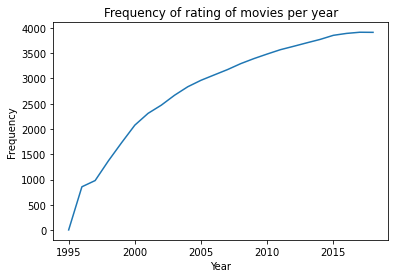

In [ ]:
# Printing frequencey of movies rated every year 
df = ratings1_with_date.groupby(by=["year","movieId"])['userId'].count()
df=pd.DataFrame(df)
df = df.reset_index()
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.plot(df.groupby("year")['movieId'].count())
plt.title("Frequency of rating of movies per year")

We observe that the number of movie ratings have an increasing trend. We therefore, decide to sample our data with the movie ratings from the most recent years in this timestamp-based sampling. 

In [ ]:
def create_timestamp_based_sample(n=100):

  # Random sampling to be used as a part of timestamp-based sampling
  def gen_sample(df,var,size):
    np.random.seed(10)
    user_cnt=df.groupby([var], as_index=False).size()
    user_cnt['decile'] = pd.qcut(user_cnt['size'], 20, labels=False,duplicates='drop')
    sample_df = user_cnt.groupby('decile').sample(frac=(size+5)/df[var].nunique())
    return(sample_df[var].to_frame().reset_index(drop=True))

  # Create new columns date and year extracted from timestamp

  ratings1_with_date = ratings1
  ratings1_with_date['date'] = [datetime.fromtimestamp(x) for x in ratings1_with_date['timestamp']]
  ratings1_with_date['date'] = pd.to_datetime(ratings1_with_date['date'])
  ratings1_with_date['year'] = ratings1_with_date['date'].dt.year

  # Sorting the ratings table with the latest dates at the top
  ratings1_with_date = ratings1_with_date.sort_values(by='date',ascending=False).reset_index().drop(columns='index')

  # Filtering for ratings given between 2005 and 2018
  ratings1_with_date_sample = ratings1_with_date[(ratings1_with_date['year']>=2005) & (ratings1_with_date['year']<=2018) ]
  ratings1_with_date_sample = ratings1_with_date_sample.drop(['date','year'],axis=1)

  # Print the number of users and movies for all ratings between 2005 and 2018
  #print("No of users between 2005 and 2018: ",ratings1_with_date_sample['userId'].nunique())
  #print("No of movies rated between 2005 and 2018: " ,ratings1_with_date_sample['movieId'].nunique())

  ratings_with_most_rated_movies = ratings1_with_date_sample

  """
  Since the number of movies is way above the 1000 movies we need, reducing number of unique movies by :
  1. aggregating number of movies per user
  2. selecting 3000 movies with highest number of user ratings
  3. joining the ratings1_with_date_sample table with the movieIds found by steps 1. and 2. to retrieve a sample with 20000+ users and most rated movies.
  """
  # Number of Movies
  ratings2GroupedByMovie = ratings1_with_date_sample.groupby(by=["movieId"]).count().reset_index()

  # Choosing top 3000 movies with maximum number of user ratings
  ratings2GroupedByMovie = ratings2GroupedByMovie.sort_values('userId', ascending=False).head(3000)

  # Mapping the movieIds obtained from above grouping table with original ratings table
  ratings_with_most_rated_movies = ratings1_with_date_sample.merge(ratings2GroupedByMovie['movieId'],how='inner',on='movieId')

  # Print the number of users and movies for most rated movies between 2005 and 2018
  #print("No of users for highly rated movies between 2005 and 2018: ", ratings_with_most_rated_movies['userId'].nunique())
  #print("No of movies for highly rated movies rated between 2005 and 2018: ", ratings_with_most_rated_movies['movieId'].nunique())

  # Method 2 : Random sampling to reduce the sample data set size 
  number_of_users = 21000 * (n/100)
  number_of_movies = 1100 * (n/100)

  ratings_with_most_rated_movies_user_sample=gen_sample(ratings_with_most_rated_movies,'userId', number_of_users)
  ratings_with_most_rated_movies_movie_sample=gen_sample(ratings_with_most_rated_movies,'movieId', number_of_movies)  

  
  ratings_with_most_rated_movies_sample=pd.merge(pd.merge(ratings1, ratings_with_most_rated_movies_user_sample, on=['userId'],how='inner'),\
                     ratings_with_most_rated_movies_movie_sample,on=['movieId'],how='inner')
  final_ratings = ratings_with_most_rated_movies_sample

  # print("Shape of final_ratings: ", final_ratings.shape)
  return final_ratings

In [ ]:
final_ratings2 = create_timestamp_based_sample(100)
final_ratings2.to_csv('/data/final_dataset.csv')

,userId,movieId,rating,timestamp,date,year
0,2,849,3.5,1192913537,2007-10-20 20:52:17,2007
1,339,849,5.0,1513001910,2017-12-11 14:18:30,2017
2,1707,849,2.5,1126569926,2005-09-13 00:05:26,2005
3,2040,849,1.0,1131363822,2005-11-07 11:43:42,2005
4,2759,849,4.0,1172969224,2007-03-04 00:47:04,2007
...,...,...,...,...,...,...
897059,279416,4090,4.0,1042467628,2003-01-13 14:20:28,2003
897060,279765,4090,3.0,1062707006,2003-09-04 20:23:26,2003
897061,279869,4090,3.0,1111569008,2005-03-23 09:10:08,2005
897062,280137,4090,3.0,1285482668,2010-09-26 06:31:08,2010


In [ ]:
# Number of Movies rated per user
final_ratings2_users_grouping = final_ratings2.groupby(by=["userId"]).count().reset_index()
print("Minimum number of ratings per user: ",final_ratings2_users_grouping["userId"].min())
print("Average number of ratings per user: ",final_ratings2_users_grouping["userId"].mean())

Minimum number of ratings per user:  2
Average number of ratings per user:  141269.95937827785


In [ ]:
print("The total number of users after timestamp based sampling are",final_ratings2.groupby(by=["userId"]).count().shape[0])

The total number of users after timestamp based sampling are 20974


In [ ]:
print("The total number of movies after timestamp based sampling are", final_ratings2.groupby(by=["movieId"]).count().shape[0])

The total number of movies after timestamp based sampling are 1103


In [ ]:
final_ratings2_movie_grouping = final_ratings2.groupby(by=["movieId"]).count().reset_index()
print("Minimum number of ratings per movie: ",final_ratings2_movie_grouping["userId"].min())
print("Average number of ratings per movie: ",final_ratings2_movie_grouping["userId"].mean())

Minimum number of ratings per movie:  137
Average number of ratings per movie:  813.2946509519493


In [ ]:
user_freq2=final_ratings2.groupby('userId', as_index=False).agg(num_movies=('movieId','count'))
movie_freq2 = final_ratings2.groupby('movieId', as_index=False).agg(num_users=('userId','count'))

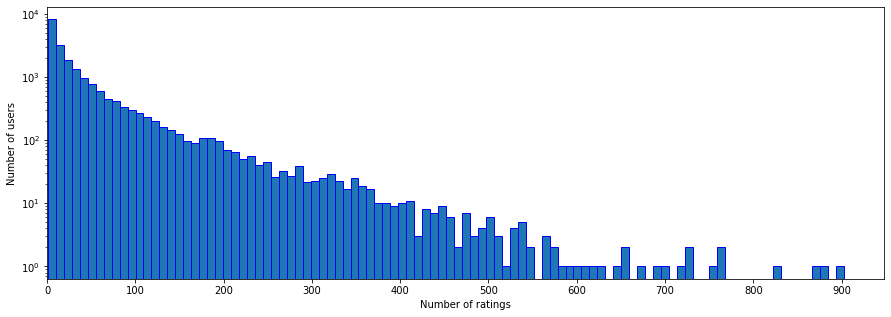

In [ ]:
plt.figure(figsize=(15,5))
plt.hist(user_freq2['num_movies'], bins=100, edgecolor='b', log=True)
plt.xlim(0,)
plt.xticks(np.arange(0,1000,100))
plt.xlabel('Number of ratings')
plt.ylabel('Number of users')
plt.show()

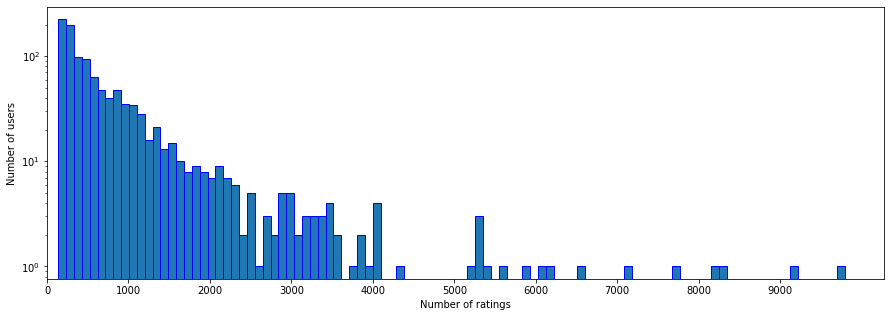

In [ ]:
plt.figure(figsize=(15,5))
plt.hist(movie_freq2['num_users'], bins=100, edgecolor='b', log=True)
plt.xlim(0,)
plt.xticks(np.arange(0,10000,1000))
plt.xlabel('Number of ratings')
plt.ylabel('Number of users')
plt.show()

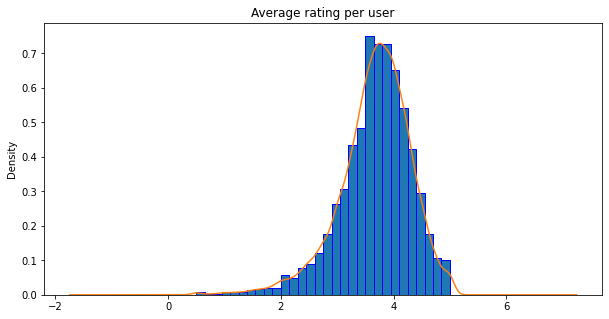

In [ ]:
df_ur_gp2 = final_ratings2[['userId','rating']].groupby('userId').agg(mean_rating=('rating','mean'))
df_ur_gp2.hist(bins=30, grid=False, edgecolor='b', density=True, figsize=(10,5))
df_ur_gp2['mean_rating'].plot(grid=False, alpha=10, kind='kde')
plt.title('Average rating per user')
plt.show()